In [1]:
pip install pyspark   #install pyspark


In [3]:
from pyspark.sql import SparkSession

# Create or get the existing Spark session
spark = SparkSession.builder.appName("BigDataAnalysis").getOrCreate()


In [5]:
import os
print(os.listdir())  # Lists all files in the current directory


['.config', 'sample_data']


In [6]:
from google.colab import files
uploaded = files.upload()  # Opens a file upload dialog


Saving big_data.csv to big_data.csv


In [7]:
print(os.listdir())  #check whether file imported or not


['.config', 'big_data.csv', 'sample_data']


In [9]:
df = spark.read.csv("/content/big_data.csv", header=True, inferSchema=True)



In [10]:
import os
print(os.listdir())  # This will show files in the current directory


['.config', 'big_data.csv', 'sample_data']


In [11]:
df.printSchema()     #Check the Schema to understand the data structure:


root
 |-- Category: string (nullable = true)
 |-- Sales: integer (nullable = true)
 |-- Date: date (nullable = true)



In [12]:
df.describe().show()  # Basic statistics for numerical columns


+-------+---------+------------------+
|summary| Category|             Sales|
+-------+---------+------------------+
|  count|       10|                10|
|   mean|     NULL|            1120.0|
| stddev|     NULL|391.01008796307144|
|    min| Clothing|               500|
|    max|Furniture|              1700|
+-------+---------+------------------+



In [13]:
df = df.dropDuplicates()    #remove duplicates


In [16]:
from pyspark.sql.functions import mean, col    #Fill missing values for numerical columns with the mean:

# Get numeric columns only (excluding Date and categorical columns)
numeric_cols = [col_name for col_name, dtype in df.dtypes if dtype in ("int", "double", "float")]

for col_name in numeric_cols:
    mean_value = df.select(mean(col(col_name))).collect()[0][0]  # Compute mean

    if mean_value is not None:
        df = df.fillna(mean_value, subset=[col_name])  # Fill missing values only for numeric columns



In [17]:
df = df.withColumn("Sales", df["Sales"].cast("float")     #Convert data types if needed:



In [18]:
from pyspark.sql.functions import col   #Create new columns

df = df.withColumn("DiscountedPrice", col("Sales") * 0.9)


In [19]:
df_filtered = df.filter(df["Sales"] > 1000)    #Filter data
df_filtered.show()


+-----------+------+----------+---------------+
|   Category| Sales|      Date|DiscountedPrice|
+-----------+------+----------+---------------+
|Electronics|1200.0|2024-01-01|         1080.0|
|Electronics|1500.0|2024-01-09|         1350.0|
|  Furniture|1300.0|2024-01-07|         1170.0|
|  Furniture|1500.0|2024-01-04|         1350.0|
|Electronics|1100.0|2024-01-06|          990.0|
|  Furniture|1700.0|2024-01-10|         1530.0|
+-----------+------+----------+---------------+



In [20]:
df_grouped = df.groupBy("Category").agg({"Sales": "sum"})     #Group by and aggregate
df_grouped.show()


+-----------+----------+
|   Category|sum(Sales)|
+-----------+----------+
|Electronics|    4700.0|
|   Clothing|    2000.0|
|  Furniture|    4500.0|
+-----------+----------+



In [21]:
df_with_date = df.withColumn("Date", df["Date"].cast("date"))     #Time-based aggregation
df_by_day = df_with_date.groupBy("Date").agg({"Sales": "sum"})
df_by_day.show()


+----------+----------+
|      Date|sum(Sales)|
+----------+----------+
|2024-01-07|    1300.0|
|2024-01-02|     500.0|
|2024-01-09|    1500.0|
|2024-01-05|     700.0|
|2024-01-04|    1500.0|
|2024-01-10|    1700.0|
|2024-01-03|     900.0|
|2024-01-08|     800.0|
|2024-01-06|    1100.0|
|2024-01-01|    1200.0|
+----------+----------+



<Axes: xlabel='Category'>

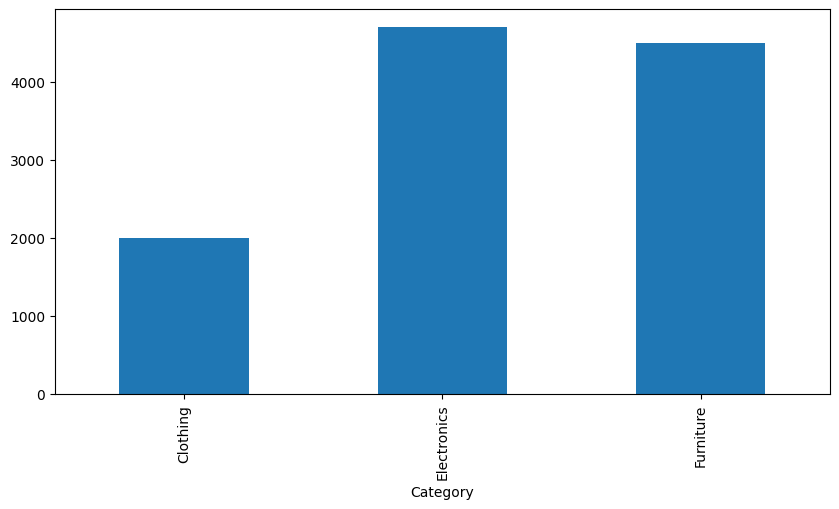

In [22]:
pdf = df.toPandas()  # Convert to Pandas DataFrame  # Data Visualization

# Plot sales by category
pdf.groupby("Category")["Sales"].sum().plot(kind="bar", figsize=(10,5))


In [23]:
df.write.csv("path/to/save/output.csv", header=True)   #Save Processed Data


In [24]:
df.write.parquet("path/to/save/output.parquet")   #save it in Parquet format for optimized storage
